In [16]:
import os
import sys
import numpy as np
from PIL import Image
os.environ['CUDA_VISIBLE_DEVICES']='1'
import time
import cv2, dlib, argparse
from utils import extract_left_eye_center, extract_right_eye_center, get_rotation_matrix, crop_image
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
from imutils.face_utils import rect_to_bb
import imutils
from helpers import FACIAL_LANDMARKS_68_IDXS
from helpers import FACIAL_LANDMARKS_5_IDXS
from helpers import shape_to_np
import numpy as np
import cv2


class FaceDetector():
    
    def __init__(self, scale=1):
        
        self.scale = scale
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("../preTrainedModel/shape_predictor_68_face_landmarks.dat")
        self.faceAligher = FaceAligner(self.predictor, desiredLeftEye=(0.32, 0.32),desiredFaceWidth=256)
        
    def get_face(self, img):
        
#         img = cv2.imread(img_path)
        height, width = img.shape[:2]
        s_height, s_width = height//self.scale, width//self.scale
        img = cv2.resize(img, (s_width, s_height))
        
        img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img_g, 1)
        
        for rect in dets:
            # extract the ROI of the *original* face, then align the face
            # using facial landmarks
            (x, y, w, h) = rect_to_bb(rect)
            faceAligned, m = self.faceAligher.align(img, img_g, rect)
            
        return faceAligned, m
    
#modified from https://github.com/jrosebr1/imutils/blob/master/imutils/face_utils/facealigner.py
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)
        
        #simple hack ;)
        if (len(shape)==68):
            # extract the left and right eye (x, y)-coordinates
            (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        else:
            (lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
            (rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
            
        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output, M
        
    

In [18]:
# scale = 1
# img = cv2.imread(input_image)
# height, width = img.shape[:2]
# s_height, s_width = height // scale, width // scale
# img = cv2.resize(img, (s_width, s_height))

# img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [119]:
from beautyGAN_main import BeautyGAN
import tensorflow as tf

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17145391500762181796
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280806708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10971872974119390709
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:07:00.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 3372285952
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 3070812817198092289
physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:84:00.0, compute capability: 3.7"
]


In [120]:
tf.reset_default_graph()

# beautyGan = BeautyGAN(prediction=True , check_dir='/tmp2/chunting/makeup/beautyGAN-tf-Implement/output/checkpoints_ori')
beautyGan = BeautyGAN(prediction=True , check_dir='checkpoints_ori')

    

Tensor("Model/generator/MirrorPad:0", shape=(1, 262, 262, 3), dtype=float32)
Tensor("Model/generator/MirrorPad_1:0", shape=(1, 262, 262, 3), dtype=float32)
Tensor("Model/generator/concat:0", shape=(1, 64, 64, 256), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints_ori/beautyGAN-319
restored  checkpoints_ori/beautyGAN-319


In [21]:
detector = FaceDetector()    

input_tgt = '../../all/image_align/makeup/6rtyryr.png'
input_tgt = './target_test.jpg'
input_tgt = './asian.jpeg'
# input_tgt = './chili.jpg'
# input_tgt = './target.png'

# input_tgt = './korea.jpeg'

input_src = './test.png'
# input_src = './test2.png'
# input_src = './Kanna.jpg'
# input_src = './yuchun.jpeg'
# input_src = './test_gakki.jpg'
# input_src = './youtube.png'


img_tgt = cv2.imread(input_tgt )
tgt_face, m = detector.get_face(img_tgt )

img_src = cv2.imread(input_src)

# img_src = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
img_src = imutils.resize(img_src, width=800)
src_face, m = detector.get_face(img_src)

height, width, ch = img_src.shape

size = (width,height)

src= cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)
tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)


src = np.expand_dims(src,0)/ 127.5 - 1
tgt = np.expand_dims(tgt,0)/ 127.5 -1


In [329]:
# #makeup transfer
# start = time.clock()
# _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup
# end = time.clock()
# output = (output + 1) * 127.5

# output = np.uint8(np.squeeze(output))
# print(end-start)

0.11380200000002105


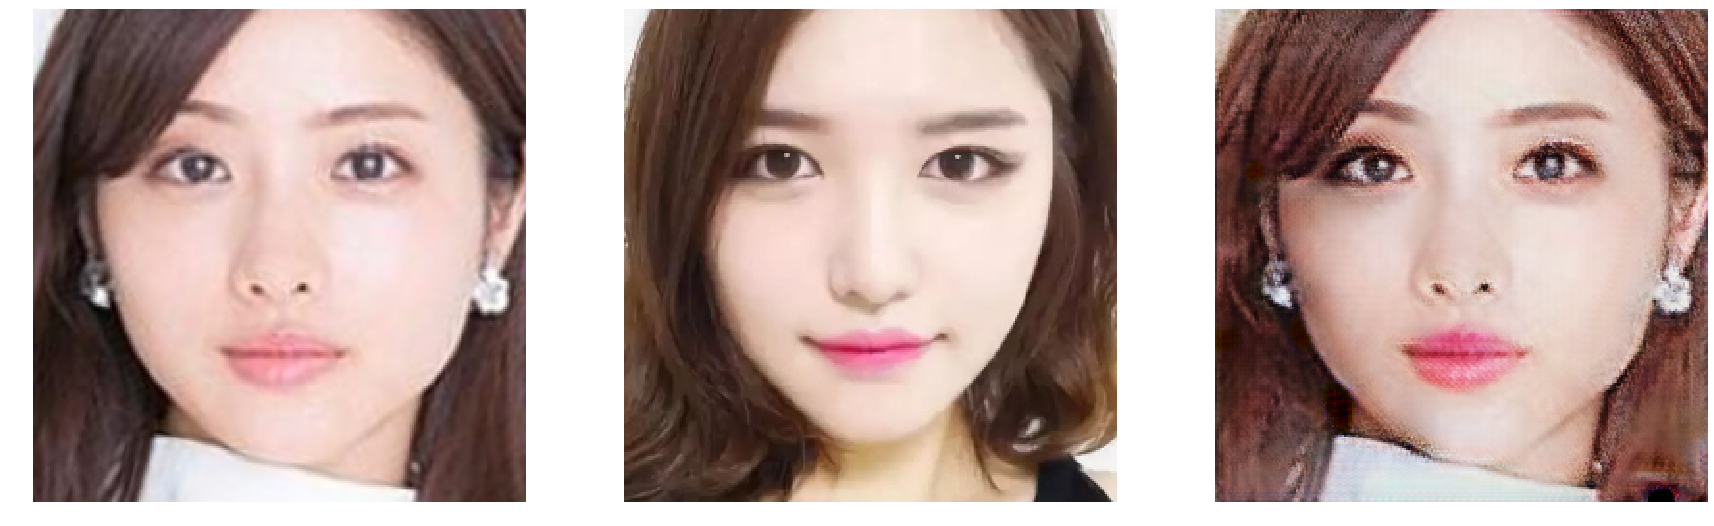

In [330]:
plt.figure(figsize=(30,10))

ax1 = plt.subplot2grid((1,3), (0,0))
ax1.imshow(cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot2grid((1,3), (0,1))
ax2.imshow(cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB))
ax2.axis('off')

ax3 = plt.subplot2grid((1,3), (0,2))
ax3.imshow(output)
ax3.axis('off')



plt.show()

(-0.5, 255.5, 255.5, -0.5)

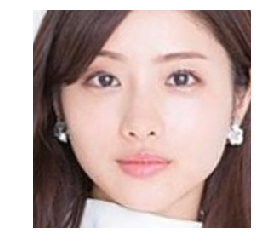

In [331]:
# plt.imshow(cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB))
# plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

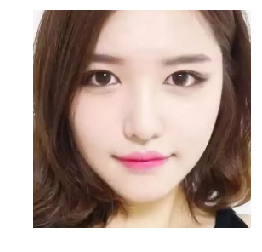

In [332]:
# plt.imshow(cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB))
# plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

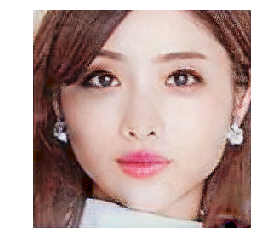

In [333]:
plt.imshow(output)
plt.axis('off')

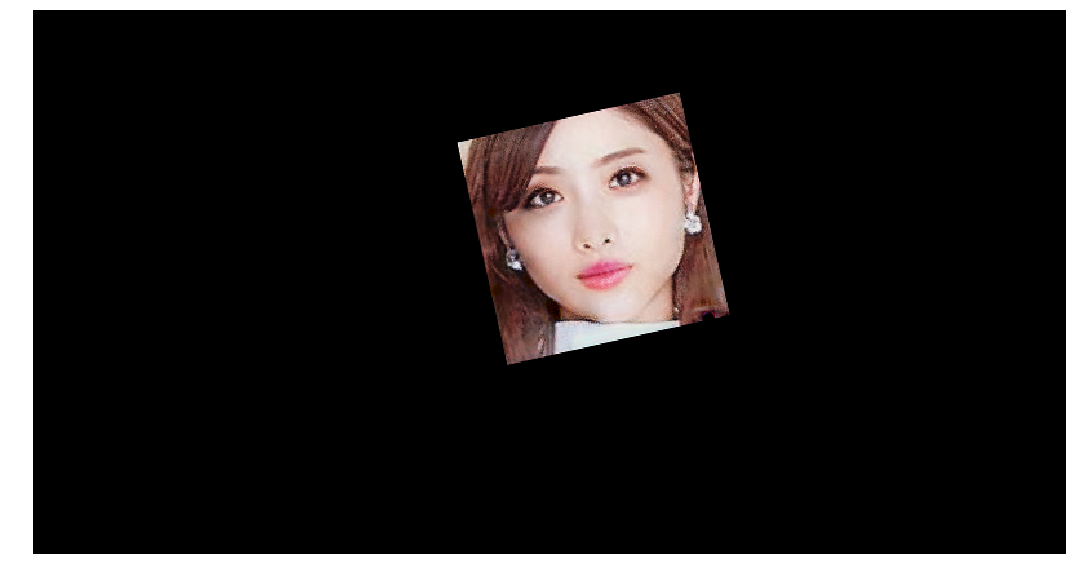

In [334]:
im = cv2.invertAffineTransform(m)
output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)


plt.figure(figsize=(20,10))
plt.imshow(output)
plt.axis('off')
plt.show()

(421, 800)


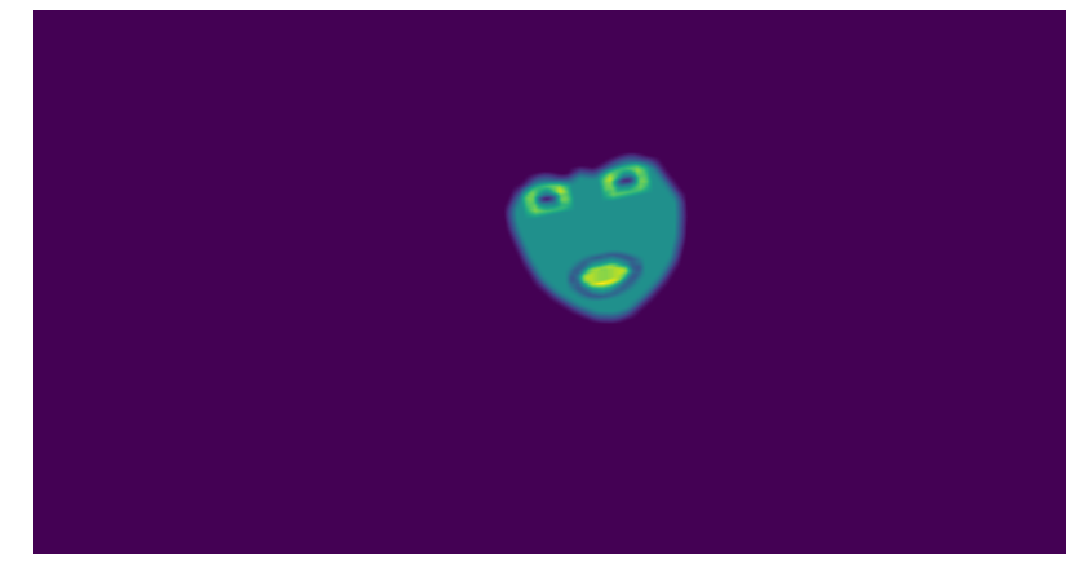

In [335]:

lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

lip_mask = lip_mask.astype(np.uint8)
face_mask = face_mask.astype(np.uint8)
eye_mask = eye_mask.astype(np.uint8)

kernel = np.ones((3,3),np.uint8)
face_mask = cv2.erode(face_mask,kernel,iterations = 5)
# face_mask = cv2.erode(face_mask,kernel,iterations = 3)

mask = np.clip(lip_mask * 1.0+ eye_mask + face_mask * 0.5 , 0, 255)


face_mask  = mask.astype(np.uint8)

face_mask = cv2.warpAffine(face_mask , im, size,flags=cv2.INTER_CUBIC)


face_mask = cv2.blur(face_mask,(10,10))


print(face_mask.shape)
plt.figure(figsize=(20,10))
plt.imshow(face_mask)
plt.axis('off')
plt.show()

In [336]:
# Read the images
foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
background = img_src
alpha = np.stack([face_mask, face_mask, face_mask],-1)

foreground = foreground.astype(float)
background = background.astype(float)
 
# Normalize the alpha mask to keep intensity between 0 and 1
alpha = alpha.astype(float)/255 


foreground = cv2.multiply(alpha, foreground)
background = cv2.multiply(1.0 - alpha, background)

outImage = cv2.add(foreground, background)
 

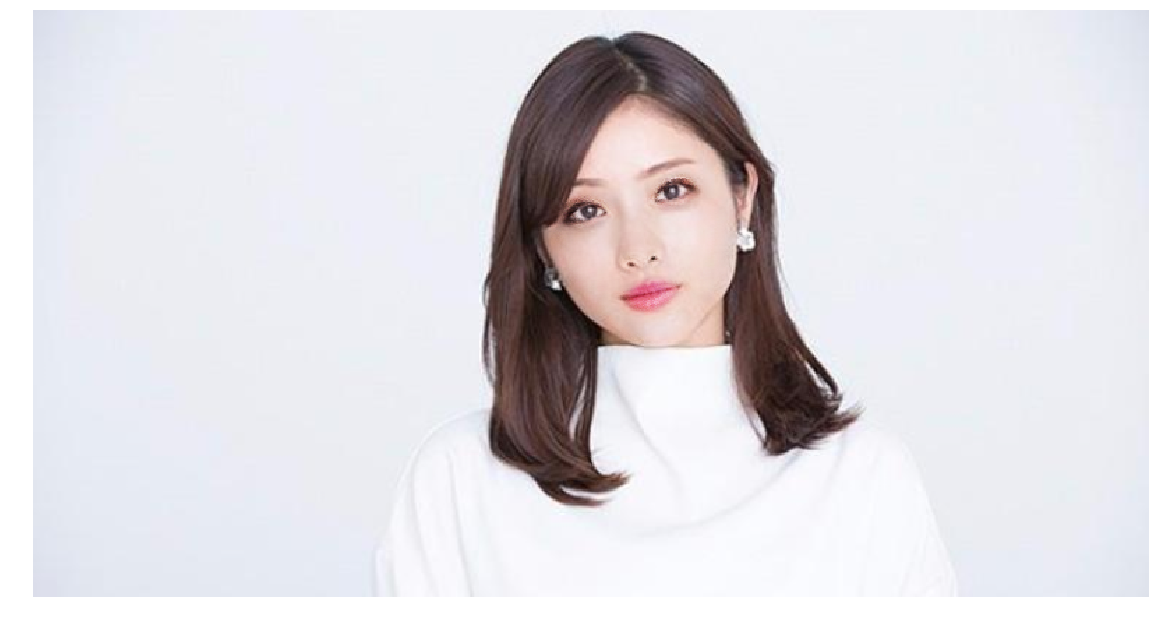

In [337]:
outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(np.squeeze(outImage))

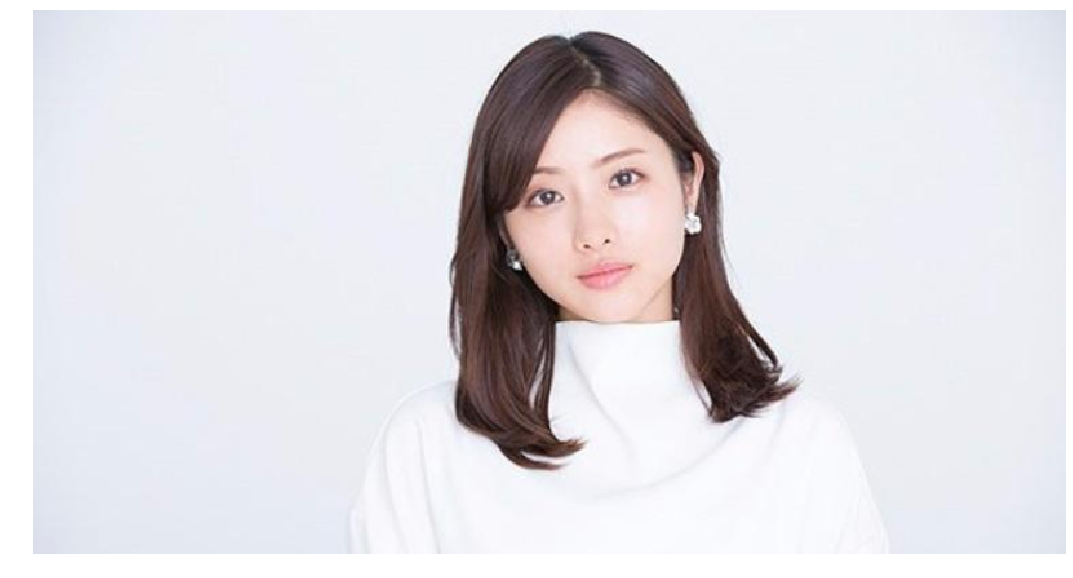

In [338]:
plt.figure(figsize=(20,10))

srcImage = cv2.cvtColor(np.uint8(img_src), cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(np.squeeze(srcImage))


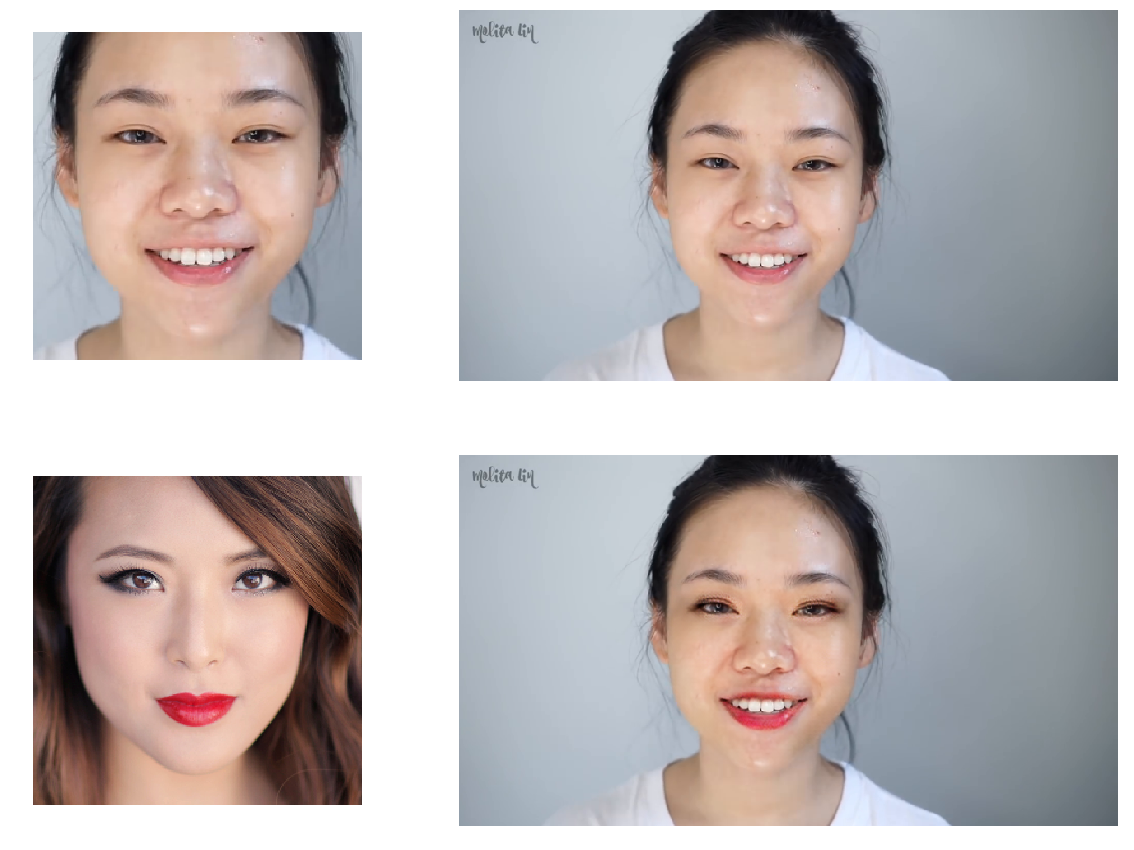

In [317]:
plt.figure(figsize=(20,15))

ax1 = plt.subplot2grid((2,3), (0,0))
ax1.imshow(cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB))
ax1.axis('off')

ax2 = plt.subplot2grid((2,3), (0,1), colspan=2)
ax2.imshow(np.squeeze(srcImage))
ax2.axis('off')

ax3 = plt.subplot2grid((2,3), (1,0))
ax3.imshow(cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB))
ax3.axis('off')

ax4 = plt.subplot2grid((2,3), (1,1), colspan=2)
ax4.imshow(np.squeeze(outImage))
ax4.axis('off')



plt.show()

In [349]:
#preprocess the data
import glob

non_makeup = glob.glob('../../all/images/non-makeup/*.png')
makeup = glob.glob('../../all/images/makeup/*.png')

In [351]:
print(len(makeup))

2719


In [698]:
output_dir = '../../all/image_align'
detector = FaceDetector()

In [700]:

scale = 1
from tqdm import tqdm

for input_image in tqdm(non_makeup):
    
    img = cv2.imread(input_image)
    height, width = img.shape[:2]
    s_height, s_width = height // scale, width // scale
    img = cv2.resize(img, (s_width, s_height))

    try:
        face, m = detector.get_face(img)
    except:
        print(input_image)
        continue

    head, tail = os.path.split(input_image)
    output_file = os.path.join(output_dir, 'non_makeup', tail)

    cv2.imwrite(output_file, face)



  7%|▋         | 74/1115 [00:07<01:38, 10.61it/s]

../../all/images/non-makeup/vSYYZ580.png


 16%|█▌        | 181/1115 [00:17<01:29, 10.40it/s]

../../all/images/non-makeup/xfsy_0088.png


 37%|███▋      | 409/1115 [00:39<01:06, 10.62it/s]

../../all/images/non-makeup/vSYYZ824.png


 42%|████▏     | 463/1115 [00:44<00:58, 11.16it/s]

../../all/images/non-makeup/vSYYZ920.png


 45%|████▌     | 507/1115 [00:48<00:57, 10.66it/s]

../../all/images/non-makeup/vSYYZ384.png


 48%|████▊     | 533/1115 [00:51<00:52, 11.05it/s]

../../all/images/non-makeup/xfsy_0148.png


 53%|█████▎    | 596/1115 [00:57<00:47, 10.83it/s]

../../all/images/non-makeup/vSYYZ874.png


 62%|██████▏   | 692/1115 [01:06<00:38, 11.01it/s]

../../all/images/non-makeup/vSYYZ523.png


 73%|███████▎  | 817/1115 [01:18<00:30,  9.78it/s]

../../all/images/non-makeup/xfsy_0483.png


100%|██████████| 1115/1115 [01:45<00:00, 11.00it/s]


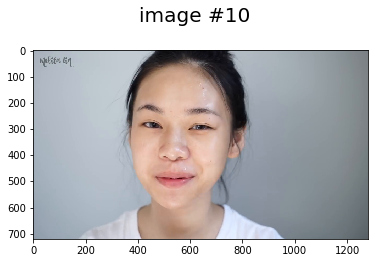

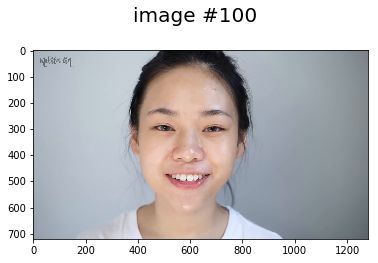

In [142]:
# import pylab
# import imageio
# filename = '../test.mp4'

# vid = imageio.get_reader(filename,  'ffmpeg')
# nums = [10, 100]
# for num in nums:
#     image = vid.get_data(num)
#     fig = pylab.figure()
#     fig.suptitle('image #{}'.format(num), fontsize=20)
#     pylab.imshow(image)
    
# pylab.show()

In [66]:
import pylab
import imageio


input_tgt = './images6.png'
filename = '../test.mp4'
img_tgt = cv2.imread(input_tgt )
tgt_face, m = detector.get_face(img_tgt )
tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)

tgt = np.expand_dims(tgt,0)/ 127.5 -1

# out.release()
cv2.destroyAllWindows() 


frame_width,frame_height  = (800, 450)
cap = cv2.VideoCapture(filename)
# out = cv2.VideoWriter('out2.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('images6.mp4', fourcc, 10, (frame_width, frame_height))


while(cap.isOpened()):
    
    ret, frame = cap.read()
    start = time.clock()
    if ret == True:
        # Display the resulting frame
        ret, frame = cap.read()
        
        img_src  = imutils.resize(frame, width=800)

        src_face, mm = detector.get_face(img_src)
        
        src = cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)
    
        src = np.expand_dims(src,0)/ 127.5 - 1

        start = time.clock()
        
        _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup
        end = time.clock()

        output = (output + 1) * 127.5
        output = np.uint8(np.squeeze(output))

        im = cv2.invertAffineTransform(mm)
        output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)

        lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

        lip_mask = lip_mask.astype(np.uint8)
        face_mask = face_mask.astype(np.uint8)
        eye_mask = eye_mask.astype(np.uint8)

        kernel = np.ones((3,3),np.uint8)
        face_mask = cv2.erode(face_mask,kernel,iterations = 5)
        # face_mask = cv2.erode(face_mask,kernel,iterations = 3)

        mask = np.clip(lip_mask * 5.0+ 2.0*eye_mask + face_mask * 0.0 , 0, 255)


        mask = mask.astype(np.uint8)

        face_mask = cv2.warpAffine(mask, im, size,flags=cv2.INTER_CUBIC)
        face_mask = cv2.blur(face_mask,(10,10))

        foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        background = img_src
        alpha = np.stack([face_mask, face_mask, face_mask],-1)
        
        print(alpha.shape)
        print(background.shape)
        
        foreground = foreground.astype(float)
        background = background.astype(float)

        # Normalize the alpha mask to keep intensity between 0 and 1
        alpha = alpha.astype(float)/255 

        foreground = cv2.multiply(alpha, foreground)
        background = cv2.multiply(1.0 - alpha, background)

        outImage = cv2.add(foreground, background)

        outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)
    
        outImage = cv2.cvtColor(outImage, cv2.COLOR_BGR2RGB)        
        out.write(outImage)
        end = time.clock()
        print(end-start)
        
        # Break the loop
    else: 
        break
        cap.release()
        
        
out.release()
cv2.destroyAllWindows() 
    


# plt.figure(figsize=(20,10))
# plt.imshow(frame)
# plt.axis('off')
# plt.show()


(450, 800, 3)
(450, 800, 3)
0.3976580000000922
(450, 800, 3)
(450, 800, 3)
0.39476799999988543
(450, 800, 3)
(450, 800, 3)
0.4348250000000462
(450, 800, 3)
(450, 800, 3)
0.376741999999922
(450, 800, 3)
(450, 800, 3)
0.41350499999998647
(450, 800, 3)
(450, 800, 3)
0.38956400000006397
(450, 800, 3)
(450, 800, 3)
0.4191720000001169
(450, 800, 3)
(450, 800, 3)
0.39802499999996144
(450, 800, 3)
(450, 800, 3)
0.39473100000009254
(450, 800, 3)
(450, 800, 3)
0.3981989999999769
(450, 800, 3)
(450, 800, 3)
0.3900710000000345
(450, 800, 3)
(450, 800, 3)
0.37374399999998786
(450, 800, 3)
(450, 800, 3)
0.41930299999989984
(450, 800, 3)
(450, 800, 3)
0.39727700000003097
(450, 800, 3)
(450, 800, 3)
0.43602999999984604
(450, 800, 3)
(450, 800, 3)
0.38945699999999306
(450, 800, 3)
(450, 800, 3)
0.4019700000001194
(450, 800, 3)
(450, 800, 3)
0.43417199999998957
(450, 800, 3)
(450, 800, 3)
0.3862900000001446
(450, 800, 3)
(450, 800, 3)
0.37763299999983246
(450, 800, 3)
(450, 800, 3)
0.42320999999992637
(

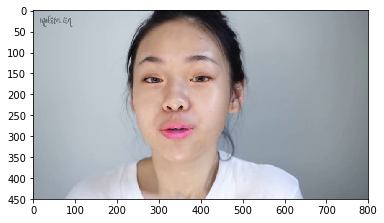

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


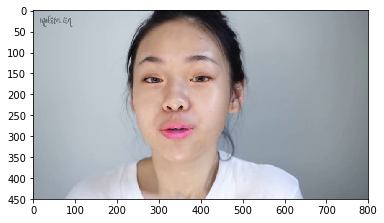

In [58]:
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

cap = cv2.VideoCapture('images2.mp4')
while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)

        display.clear_output(wait=True)
        display.display(plt.gcf())

    except KeyboardInterrupt:
        cap.release()

In [57]:
# import cv2
# import matplotlib.pyplot as plt
# from IPython import display
# %matplotlib inline

import io
import base64
from IPython.display import HTML

video = io.open('images2.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

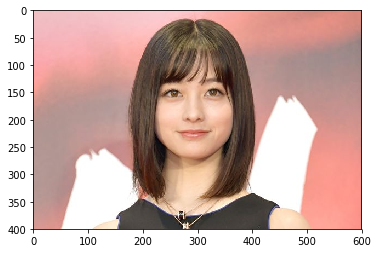

In [43]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

plt.figure(figsize=(20,15))
ax2 = plt.subplot2grid((1,3), (0,1))
# input_tgt = './asian.jpeg'
input_tgt = './Kanna.jpg'
# input_tgt = '../../all/image_align/makeup/6rtyryr.png'
# input_tgt = './target_test.jpg'
img_tgt = cv2.imread(input_tgt )
ax2.imshow(cv2.cvtColor(img_tgt, cv2.COLOR_BGR2RGB))
plt.show()

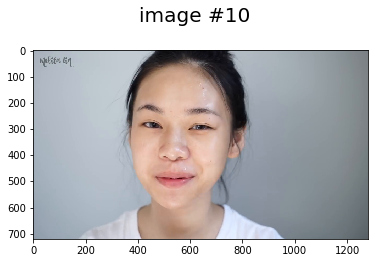

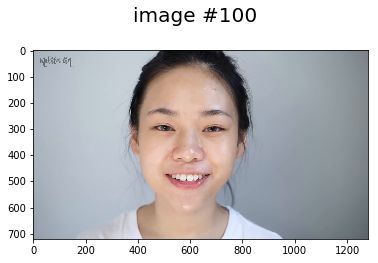

In [54]:
import pylab
import imageio
filename = '../test.mp4'

vid = imageio.get_reader(filename,  'ffmpeg')
nums = [10, 100]
for num in nums:
    image = vid.get_data(num)
    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
    
pylab.show()

In [38]:
import pylab
import imageio
filename = '../test.mp4'

vid = imageio.get_reader(filename,  'ffmpeg')

detector = FaceDetector()    

# input_tgt = '../../all/image_align/makeup/6rtyryr.png'
# input_tgt = './target_test.jpg'
input_tgt = './images3.jpg'
# input_tgt = './chili.jpg'
# input_tgt = './target.png'


img_tgt = cv2.imread(input_tgt )
tgt_face, m = detector.get_face(img_tgt )
tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('asian.mp4', fourcc, 10, (frame_width, frame_height))


tgt = np.expand_dims(tgt,0)/ 127.5 -1


for i, im in enumerate(vid):
    
    
    img_src = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    img_src = imutils.resize(img_src, width=800)
    src_face, m = detector.get_face(img_src)

    height, width, ch = img_src.shape
    size = (width,height)
    print(size)
    src = cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)
    
    src = np.expand_dims(src,0)/ 127.5 - 1
    
    start = time.clock()
    _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup
    end = time.clock()
    
    output = (output + 1) * 127.5

    output = np.uint8(np.squeeze(output))
    
    
    im = cv2.invertAffineTransform(m)
    output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)
    
    lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

    lip_mask = lip_mask.astype(np.uint8)
    face_mask = face_mask.astype(np.uint8)
    eye_mask = eye_mask.astype(np.uint8)

    kernel = np.ones((3,3),np.uint8)
    face_mask = cv2.erode(face_mask,kernel,iterations = 5)
    # face_mask = cv2.erode(face_mask,kernel,iterations = 3)

    mask = np.clip(lip_mask * 5.0+ 2.0*eye_mask + face_mask * 0.0 , 0, 255)


    mask = mask.astype(np.uint8)

    face_mask = cv2.warpAffine(mask, im, size,flags=cv2.INTER_CUBIC)
    face_mask = cv2.blur(face_mask,(10,10))
    
    
    foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    background = img_src
    alpha = np.stack([face_mask, face_mask, face_mask],-1)

    foreground = foreground.astype(float)
    background = background.astype(float)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255 


    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)

    outImage = cv2.add(foreground, background)
    
    outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)
    
    out.write(outImage)

    print(end-start)
    
    break

(800, 450)
0.11726899999999318


In [116]:
import pylab
import imageio


def get_makeup_image(input_src, input_tgt):
    
    img_tgt = cv2.imread(input_tgt )
    img_tgt = imutils.resize(img_tgt, width=800)
    tgt_face, m = detector.get_face(img_tgt )
    tgt = cv2.cvtColor(tgt_face, cv2.COLOR_BGR2RGB)
    tgt = np.expand_dims(tgt,0)/ 127.5 -1
    
    img_src = cv2.imread(input_src )
    img_src = imutils.resize(img_src, width=800)
    src_face, m = detector.get_face(img_src )
    src = cv2.cvtColor(src_face, cv2.COLOR_BGR2RGB)
    src = np.expand_dims(src,0)/ 127.5 -1

    height, width, ch = img_src.shape
    size = (width,height)
    
    _, output = beautyGan.predict(src,tgt) # src:non makeup target: makup

    output = (output + 1) * 127.5

    output = np.uint8(np.squeeze(output))


    im = cv2.invertAffineTransform(m)
    output = cv2.warpAffine(output, im, size,flags=cv2.INTER_CUBIC)

    lip_mask, eye_mask, face_mask = beautyGan.get_mask(src_face, detector.detector, detector.predictor)

    lip_mask = lip_mask.astype(np.uint8)
    face_mask = face_mask.astype(np.uint8)
    eye_mask = eye_mask.astype(np.uint8)

    kernel = np.ones((3,3),np.uint8)
    face_mask = cv2.erode(face_mask,kernel,iterations = 5)
    # face_mask = cv2.erode(face_mask,kernel,iterations = 3)

    mask = np.clip(lip_mask * 3.0+ 1.0*eye_mask + face_mask * 1.0 , 0, 255)


    mask = mask.astype(np.uint8)

    face_mask = cv2.warpAffine(mask, im, size,flags=cv2.INTER_CUBIC)
    face_mask = cv2.blur(face_mask,(10,10))


    foreground = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    background = img_src
    alpha = np.stack([face_mask, face_mask, face_mask],-1)

    foreground = foreground.astype(float)
    background = background.astype(float)

    # Normalize the alpha mask to keep intensity between 0 and 1
    alpha = alpha.astype(float)/255 


    foreground = cv2.multiply(alpha, foreground)
    background = cv2.multiply(1.0 - alpha, background)

    outImage = cv2.add(foreground, background)

    outImage = cv2.cvtColor(np.uint8(outImage), cv2.COLOR_BGR2RGB)
    
    return outImage

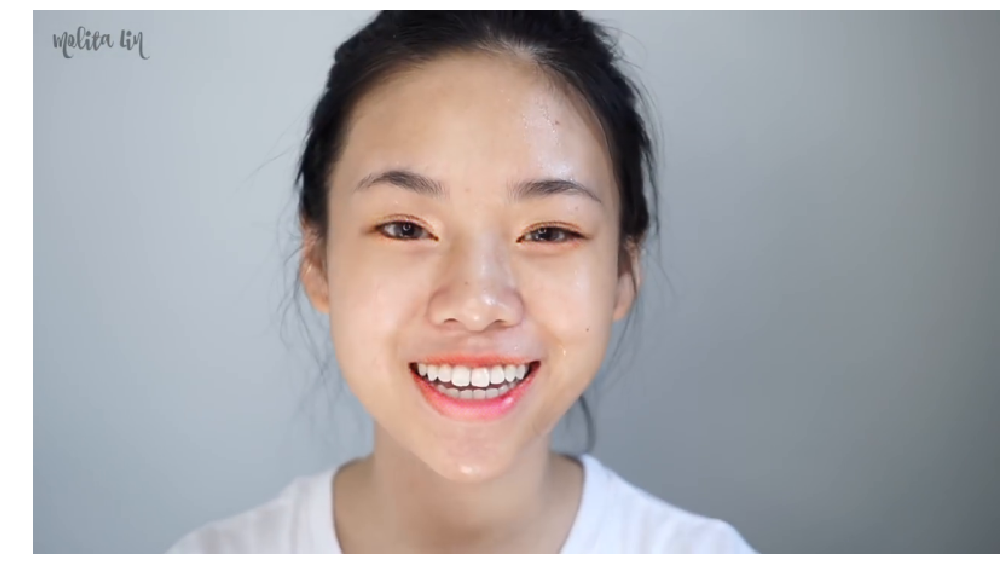

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(outImage)
plt.axis('off')
plt.show()

In [117]:
input_tgt = './images.jpeg'

input_src = './images3.jpg'

outImage = get_makeup_image(input_src, input_tgt)

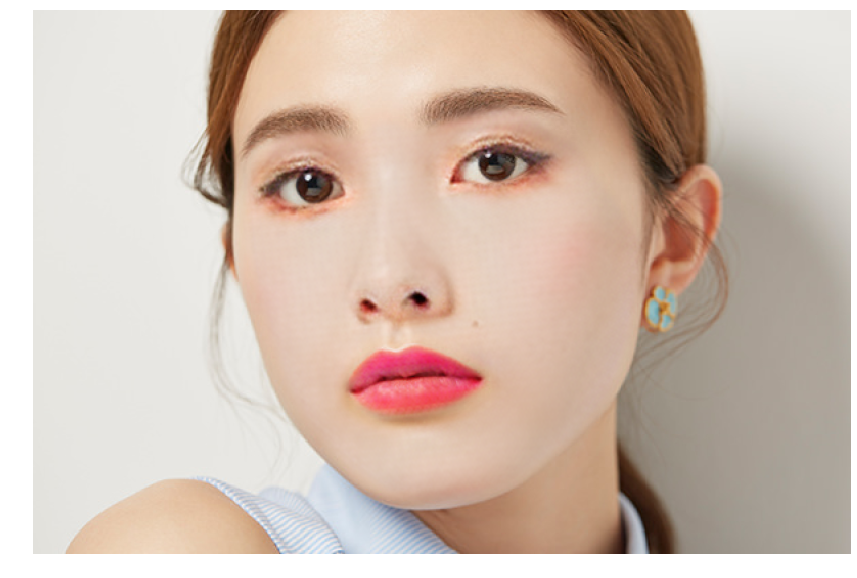

In [118]:
plt.figure(figsize=(20,10))
plt.imshow(outImage)
plt.axis('off')
plt.show()

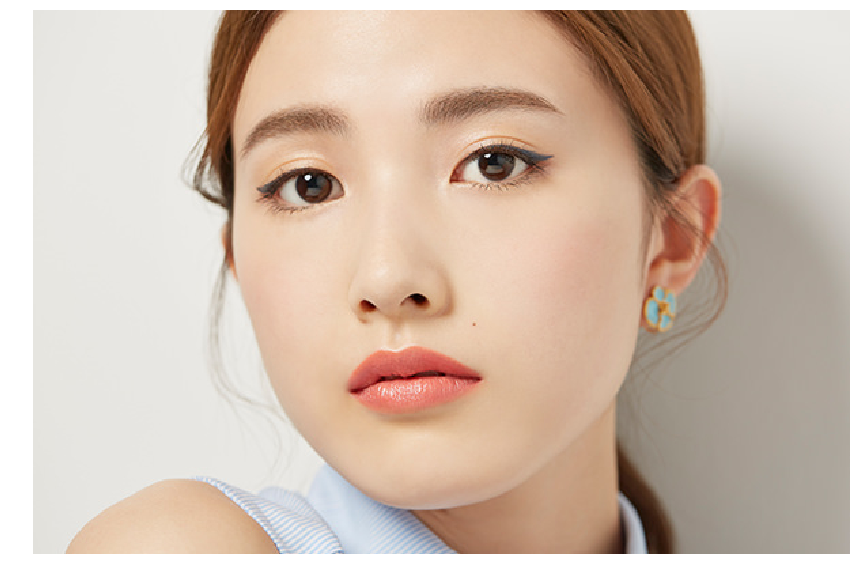

In [112]:
input_src = './images3.jpg'
img_src = cv2.imread(input_src )
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_src)
plt.axis('off')
plt.show()

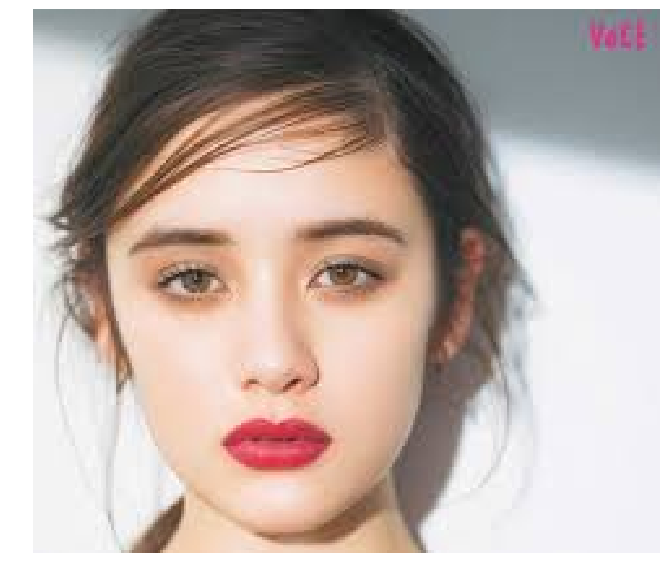

In [115]:
input_src = './images.jpeg'
img_src = cv2.imread(input_src )
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img_src)
plt.axis('off')
plt.show()